# HW 3: Unsupervised Learning

Generating data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def generaterow(length, variance):
    noise = lambda m, v: np.random.normal(loc=m, scale=np.sqrt(v))

    row = [0]*length
    row[0] = np.random.normal(loc=0, scale=1) # x1
    row[1] = row[0] + noise(0,variance)
    row[2] = row[0] + noise(0,variance)
    row[3] = row[0] + noise(0,variance)
    for i in range(4, length):
        row[i] = row[i-3] + noise(0,variance)

    return row

In [3]:
def initDataframe(length):
    columns = [f'x{i}' for i in range(1,length+1)]
    df = pd.DataFrame(columns=columns)

    return df

In [4]:
def populateDataframe(df, length, rows, variance):
    for _ in range(rows):
        df.loc[len(df.index)] = generaterow(length, variance)
    
    return df

## Problem 1: Auto Encoders

In [5]:
def createWmatrices(k):
    W1 = np.random.normal(loc=0, scale=0.01, size=(k,30))
    W2 = np.random.normal(loc=0, scale=0.01, size=(30,k))
    return W1, W2

In [6]:
def train(dfnp, W1, W2, alpha, iters, k):
    def tanhderiv(x):
        return 1-(np.tanh(x))**2

    for i in range(iters):
        d = dfnp[np.random.randint(0,dfnp.shape[0])] 

        # forward pass
        x1 = np.tanh(W1@d) # kx1
        x2 = W2@x1 # 30x1

        # backward pass
        delta2 = 2*(x2-d) 
        delta2r = np.reshape(delta2, (30,1))
        x1r = np.reshape(x1, (k,1)) 
        dLdw2 = delta2r@x1r.T # 30xk (dL/dW2 = dL/dx2 * dx2/dW2 = dL/dx2 * constant * x1)

        delta1 = ((W2.T@delta2)*tanhderiv(W1@d)) # kx30*30x1
        delta1r = np.reshape(delta1, (k,1))
        dr = np.reshape(d, (30,1))
        dLdw1 = delta1r@dr.T # kx30 (dL/dW1 = dL/dx1 * dx1/dW1 = (dL/dx2.dx2/dx1) * d*tanh'(W1.d))

        # update step
        W1 -= alpha*dLdw1
        W2 -= alpha*dLdw2
        # print(W2)
    
    loss = 0
    for datapoint in dfnp:
        loss += (np.linalg.norm(datapoint-(W2@(np.tanh(W1@datapoint)))))**2
    loss /= dfnp.shape[0]
    return loss

In [7]:
def producelosses(df, k, sigmasq, alpha, iters):
    w1, w2 = createWmatrices(k)

    L = train(df.to_numpy(), w1, w2, alpha, iters, k)
    # print(round(L,2), end=' ')
    return L

In [8]:
def generategraph(sigmasq, alpha, iters):
    ks = np.arange(1,31,1)
    losses = []

    df = initDataframe(30)
    df = populateDataframe(df, 30, 5000, sigmasq)

    for k in ks:
        # print(k)
        L = producelosses(df, k, sigmasq, alpha, iters)
        losses.append(L)
        # print()
    
    plt.figure()
    plt.plot(ks, losses)
    plt.title("k vs Loss")
    plt.xlabel("k (Hidden nodes)")
    plt.ylabel("Loss")
    plt.show()

0.0


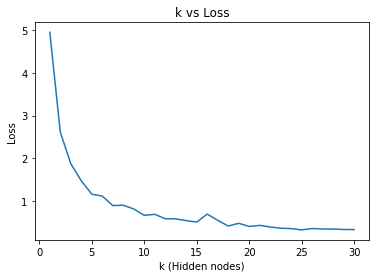

0.18181818181818182


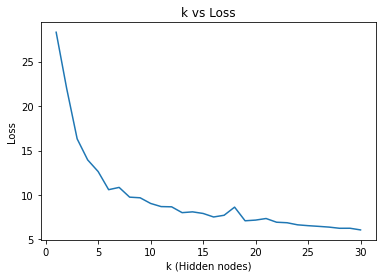

0.36363636363636365


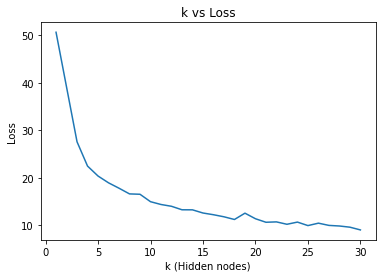

0.5454545454545454


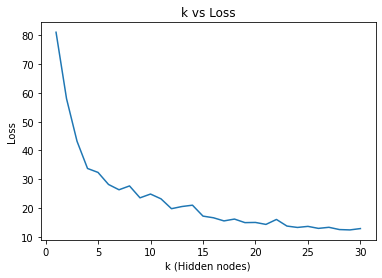

0.7272727272727273


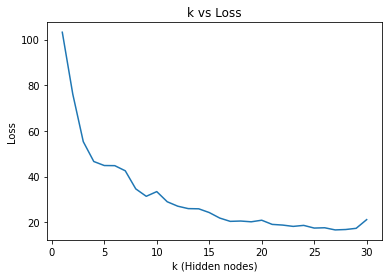

0.9090909090909092


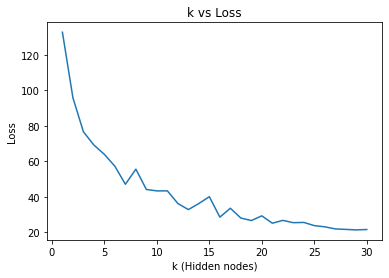

1.0909090909090908


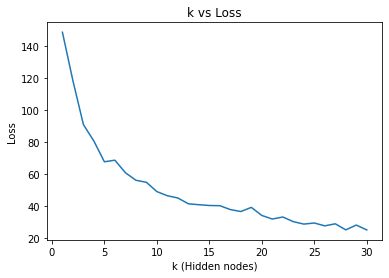

1.2727272727272727


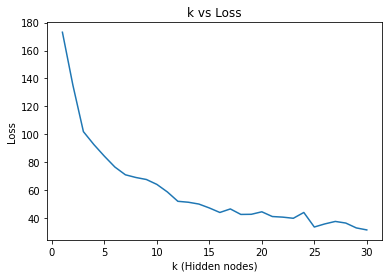

1.4545454545454546


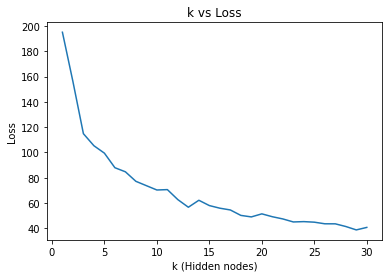

1.6363636363636365


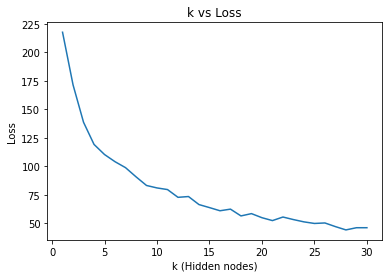

1.8181818181818183


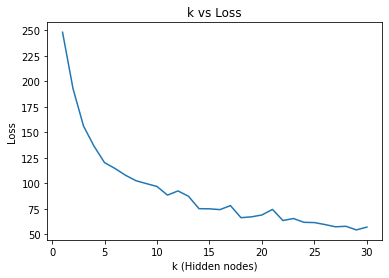

2.0


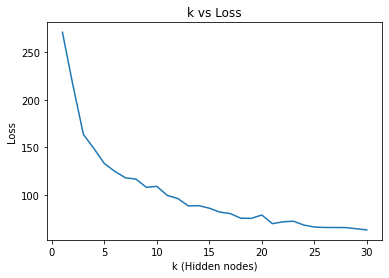

In [10]:
sigmasqs = np.linspace(0,2,12)
for sigmasq in sigmasqs:
    print(f'sigma^2 is {sigmasq}')
    generategraph(sigmasq, 0.001, 3000) # takes around 1-2 mins to run

There is a slight progression of each graph having an "elbow" slightly farther down the k axis than the previous graph, from k=1 or 2 being ideal for sigma=0 to k=5 or 6 as sigma tends to 2, as suggested by the sharp drop in the first graph becoming less steep as sigma increases. This suggests that for higher values of sigma, the dataset needs a higher number of dimensions to accurately represent the data, which makes sense and is consistent with the results from the PCA analysis in the next section. The advantage of autoencoders is nonlinear dimensionality reduction, but as there aren't nonlinear relationships between the features in the dataset, there is not much of an distinct benefit here, which translates to much of the same results as the next section. The graphs themselves do seem to smooth themselves out as sigma increases, taking on more of the ideal elbow shape. This is because the graphs themselves are on a larger scale for loss (which can be explained as higher noise in the data would produce higher loss for all values of k), meaning individual bumps or inaccuracies with the algorithm are less noticeable. The existence of these bumps in the first place can be accounted for by suboptimal hyperparameters or the fact that I used SGD (optimize one datapoint at a time) rather than Batch Gradient Descent, possibly sacrificing accuracy for speed. Had I tweaked my alpha and iterations or experimented with larger batch sizes, the results would've been different. Overall, however, the trend in the graphs is clear and is consistent with previous knowledge.

## Problem 2: PCA

In [21]:
df2 = initDataframe(30)
df2 = populateDataframe(df2, 30, 5000, 0.1)

First, let's mean center the data.

In [22]:
xtx = np.matmul(np.transpose(df2), df2.to_numpy())
xtx.mean()[:5]

0    5071.446659
1    5231.026247
2    5254.989425
3    5204.271840
4    5407.511216
dtype: float64

In [23]:
xtxcenter = xtx.apply(lambda x: x-x.mean())

In [24]:
xtxcenter

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
x1,-27.099899,-186.129207,-198.829532,-177.064283,-353.594726,-340.288572,-301.163331,-490.831860,-472.724370,-417.661053,...,-842.120622,-718.110996,-908.809588,-886.681366,-750.525224,-925.453975,-917.466174,-777.566246,-937.272723,-937.489130
x2,-26.549619,303.747724,-193.249600,-172.067634,141.187256,-347.669732,-304.217981,9.247337,-477.178702,-414.239545,...,-860.476441,-720.730814,-416.425057,-903.353364,-759.000657,-426.991403,-945.466579,-780.832234,-432.957935,-962.633311
x3,-15.286766,-169.286423,316.612100,-166.483446,-325.492239,179.009835,-298.980986,-455.773732,51.731653,-414.890228,...,-315.938649,-717.018713,-888.863428,-357.312001,-756.559363,-909.829056,-387.887681,-788.571034,-928.187560,-410.365193
x4,-44.239102,-198.822041,-217.201031,312.072315,-368.941510,-352.882115,191.468015,-512.886786,-497.715258,75.052433,...,-852.902490,-222.459130,-940.716733,-895.146698,-259.195358,-966.328398,-922.263898,-275.377286,-985.938175,-939.557414
x5,-17.530169,317.672225,-172.970447,-165.702134,665.978036,-320.201052,-291.479398,538.208215,-445.983516,-400.833641,...,-807.904536,-705.189764,109.685839,-846.265057,-747.043967,87.581680,-877.413274,-770.728439,68.877339,-886.409567
x6,-25.710145,-192.670893,310.045496,-171.128869,-341.687182,659.569649,-315.064414,-483.858964,531.653801,-435.210342,...,144.219387,-735.300090,-886.312794,94.347541,-785.863993,-908.019717,77.570268,-800.794378,-927.043144,53.847364
x7,-30.841957,-193.476196,-212.202378,328.964207,-357.222582,-359.321467,701.646428,-498.047795,-515.193479,590.229227,...,-872.986728,290.865434,-925.810823,-907.131818,255.369993,-956.730865,-939.180787,247.572372,-982.066936,-953.447068
x8,-46.316457,294.183151,-194.801095,-201.196565,646.659061,-353.921989,-323.853766,1022.064298,-480.767906,-431.829292,...,-824.167647,-739.296442,598.888390,-863.248031,-771.373520,569.384988,-897.292210,-793.469602,557.706278,-908.632108
x9,13.885150,-150.148770,354.798407,-143.930920,-295.438553,703.684893,-298.905333,-438.673789,1079.798807,-415.510151,...,700.495807,-709.394914,-838.782194,647.271395,-760.444479,-871.938301,626.115952,-777.497335,-897.928788,608.000637
x10,-38.282499,-194.440579,-219.054439,321.605806,-357.519644,-370.410215,699.286407,-496.966141,-522.741116,1079.971994,...,-866.951229,766.935988,-943.713118,-909.563308,748.295786,-972.013451,-951.871344,736.658744,-990.000208,-969.177481


In [25]:
def principalcomponents(df, tolerance):
    xtx = np.matmul(np.transpose(df), df.to_numpy())
    xtxcenter = xtx.apply(lambda x: x-x.mean())
    vals, vecs = np.linalg.eig(xtxcenter)
    cumul = np.array([sum(vals[0:i+1])/sum(vals) for i in range(30)])
    return sum(cumul<tolerance)

In [26]:
vals, vecs = np.linalg.eig(xtxcenter)

In [27]:
vals

array([ 2.26947550e+04,  1.97650866e+04,  5.07615582e+03,  2.59693429e+03,
        2.18700704e+03,  1.28475162e+03,  9.34257364e+02,  8.35978577e+02,
        5.93909278e+02,  5.07090072e+02,  4.46809708e+02,  3.64321265e+02,
       -1.95977227e-11,  3.18750734e+02,  2.76260936e+02,  2.52799012e+02,
        2.36962843e+02,  2.09055763e+02,  1.92482504e+02,  1.81891606e+02,
        1.11675505e+02,  1.24103521e+02,  1.26766685e+02,  1.30335295e+02,
        1.37237256e+02,  1.39098514e+02,  1.61096375e+02,  1.59438844e+02,
        1.49316950e+02,  1.51481458e+02])

In [30]:
# this just adds up each subsequent eigenvalue, divides by the sum. for example [1,2,3,4] -> [1/10,3/10,6/10,10/10]
cumul = np.array([sum(vals[0:i+1])/sum(vals) for i in range(30)])

# sees how many eigenvalues account for 90% of the total spread of data
print(sum(cumul<0.9))

6


In [56]:
sigmas = np.linspace(0, 2, 12)
comps = []

for sigma in sigmas:
    df2 = initDataframe(30)
    df2 = populateDataframe(df2, 30, 5000, sigma)
    # print(round(sigma,2), principalcomponents(df2, 0.9))
    comps.append(principalcomponents(df2, 0.9))

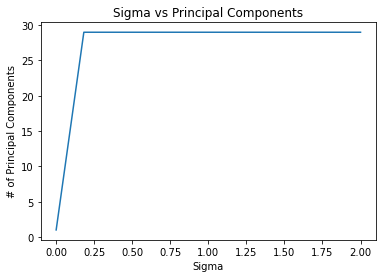

In [55]:
plt.figure()
plt.plot(sigmas, comps)
plt.title("Sigma vs Principal Components")
plt.xlabel("Sigma")
plt.ylabel("# of Principal Components")
plt.show()

After repeating this for multiple datasets by rerunning the cells, the results seem robust. If we account for 90% of the spread of the data, then 6 dimensions is all we need to represent the data. As (most of) the eigenvalues are within 1-2 orders of magnitude from each other, definitively declaring the dataset to be best represented as a certain fixed number of dimensions might not be the best idea. Instead, depending on the tolerance we have for the error of our model, or how much of the original "spread" we want to retain (in this case, 90%), we can decide on the corresponding number of dimensions. If I had set this threshold to be lower, the number of dimensions would've been fewer. This decision of a threshold is akin to looking at an k vs loss graph for an autoencoder and visually deciding where the elbow is: a higher threshold corresponds to farther down on the elbow and vice-versa. The extreme case of the variance being 0 also makes sense. In that case, all the features would have been exactly equal to each other, and so all of the dimensions would've basically been redundant and able to be described in one dimension. The result does not seem to change as sigma increases, which can most likely be explained by the fact that all of the eigenvalues for a given sigma are relatively distanced away from each other, escpecially so for the greatest values, so the cumulative sum would also take relatively large leaps for every new eigenvalue. This would explain how a large range of the cumulative sum up to 6 would fall under the threshold of 0.9, so greater levels noise would not affect the result as much as expected.

## Part 3: Correlation Graphs

For this part, we can iterate over the features and have each one take turns being the output value, to get 30 distinct datasets. We can apply linear regression on each one and then check which 2 or 4 features are the most influential in predicting the output feature to build the dependency graph.

In [33]:
df3 = initDataframe(30)
df3 = populateDataframe(df3, 30, 5000, 0.1)

In [34]:
df3.iloc[:,0:]

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30
0,0.052392,0.145602,0.229808,0.012326,0.706335,0.946254,-0.378401,0.932675,1.401671,-0.092657,...,1.532920,0.024947,1.539454,2.110254,-0.374013,1.195348,2.047093,-0.282683,1.120642,2.122028
1,-0.084792,0.339375,-0.318966,-0.512148,0.101927,-0.244808,-0.644104,0.274157,-0.051741,-0.735246,...,0.494297,-0.691266,-0.500565,0.695900,-0.706331,-0.285214,0.533630,-0.785672,-0.173207,0.790511
2,-1.109300,-1.095934,-0.222420,-1.191907,-0.899408,-0.260737,-1.232076,-0.549288,-0.300644,-0.833908,...,-0.733014,-1.203184,-0.684139,-1.178057,-1.637562,-0.319731,-1.433140,-1.676017,0.215247,-1.928641
3,1.706067,1.265121,2.076250,2.485236,1.275382,1.233876,2.560742,1.030883,1.716075,2.102605,...,3.435217,2.086736,0.211992,3.514984,1.852925,0.227290,3.963418,1.745227,0.508625,3.469782
4,-0.663319,-0.645465,-0.496944,-0.384604,-0.626682,0.416027,-0.418630,-0.399368,0.995350,0.371971,...,1.023036,1.381041,-0.280530,0.959780,1.478829,-0.649981,0.800596,1.294015,-0.739352,0.809409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.375338,-0.641238,-0.416797,-0.466950,-0.715395,-0.564801,-0.989637,-0.463393,-0.597969,-0.971390,...,-0.632885,-1.137053,-0.785549,-0.902396,-1.144240,-0.838368,-0.417680,-1.025384,-0.948384,-0.255116
4996,2.388945,2.277536,1.823901,2.803768,2.002244,1.566848,2.670638,1.420014,2.018134,2.431887,...,2.394710,2.533628,1.678488,2.773522,2.316052,1.194753,2.507596,2.158409,1.107420,2.780524
4997,-0.518056,-0.252381,-0.253737,-0.632964,-0.476212,-0.148445,-0.297194,-0.450769,-0.088984,0.075874,...,0.339022,0.490968,-0.406738,0.215969,0.694024,-0.914704,-0.134108,1.260372,-0.900899,-0.604481
4998,0.358957,0.247804,0.447113,0.016707,0.095768,0.211050,0.514062,0.830457,0.165150,0.848865,...,-0.116682,0.185552,0.448356,-0.617193,0.396605,0.323071,-0.291254,0.118493,0.067235,0.179250


In [35]:
def traintestsplit(df):
    m,n = df.shape
    dfxtrain = df.iloc[0:int(0.9*m), 0:-1]
    dfytrain = df.iloc[0:int(0.9*m), -1]
    dfxtest = df.iloc[int(0.9*m):, 0:-1]
    dfytest = df.iloc[int(0.9*m):, -1]

    return dfxtrain, dfytrain, dfxtest, dfytest

In [36]:
def OLS(df_x, df_y): # taken from HW 1
    df_x_cols = df_x.columns
    df_y_col = df_y.name
    df_x_np = df_x.to_numpy()
    df_y_np = df_y.to_numpy()
    multi = np.matmul(df_x_np.transpose(), df_x_np)
    multi_inv = np.linalg.inv(multi)
    multi_inv_times_trans = np.matmul(multi_inv, df_x_np.transpose())
    w_star = np.matmul(multi_inv_times_trans, df_y_np)

    return w_star, df_x_cols, df_y_col

In [37]:
def maxdependentfeatures(df3, number):
    dependencytable = pd.DataFrame(index=df3.columns.copy(), columns=range(number))

    for i in range(1, df3.shape[1]+1): # iterate over all features
        df3 = df3[[c for c in df3.columns if c not in [f'x{i}']]+[f'x{i}']] # to move column to end
        x = df3.iloc[:,0:-1]
        y = df3.iloc[:,-1]
        w, xes, yname = OLS(x, y)
        # print(xes.shape, w.shape)
        together = [(xes[i], w[i]) for i in range(w.shape[0])]

        togethersort = sorted(together, key=lambda x: x[1], reverse=True) # sorts by weight
 
        dependencytable.iloc[i-1] = [(f'{togethersort[j][0]}', togethersort[j][1]) for j in range(number)]
    
    return dependencytable


In [51]:
maxdependentfeatures(df3, 3)

,0,1,2
x1,"(x2, 0.3253070330190176)","(x3, 0.31939754768347595)","(x4, 0.2938046101165139)"
x2,"(x1, 0.5120368727579679)","(x5, 0.4907053351639653)","(x16, 0.03447317674595039)"
x3,"(x1, 0.5025856899680302)","(x6, 0.4917974885034643)","(x20, 0.03882176529294436)"
x4,"(x7, 0.5168312166275981)","(x1, 0.4851658814611524)","(x16, 0.024467898159086954)"
x5,"(x2, 0.49795223309261966)","(x8, 0.49608662889510646)","(x13, 0.040228566131344595)"
x6,"(x9, 0.5151763356213523)","(x3, 0.5002559366837562)","(x17, 0.024794919858333993)"
x7,"(x4, 0.49313257523828297)","(x10, 0.4924918553839932)","(x26, 0.033799397956022506)"
x8,"(x11, 0.5036505557957746)","(x5, 0.49200638497158145)","(x16, 0.0376165319894541)"
x9,"(x6, 0.5068327577031864)","(x12, 0.4966050169236801)","(x4, 0.022713213072285746)"
x10,"(x13, 0.4998979779791356)","(x7, 0.4953952214283649)","(x23, 0.027543751842921353)"


To implement and view the correlation graph, let's import the python library NetworkX.

In [38]:
import networkx as nx

In [39]:
def createdependency(features, sigmasq):
    newdf = initDataframe(30)
    newdf = populateDataframe(newdf, 30, 5000, sigmasq)
    
    ndtab = maxdependentfeatures(newdf, features)

    return ndtab
    

In [40]:
def buildgraph(dtab): # inputs dependency table
    G = nx.DiGraph()

    for x in dtab.index:
        G.add_node(x)
        
    for i in dtab.index:
        temp = []
        for j in dtab.columns:
            # print(dtab.loc[i,j], end=" ")
            if dtab.loc[i,j] is not None:
                temp.append((dtab.loc[i,j][0], i, round(dtab.loc[i,j][1], 4))) # node from, node to, weight
        G.add_weighted_edges_from(temp)
    
    return G


In [41]:
def displaygraph(G, numf):
    pos = nx.spectral_layout(G)
    nx.draw_networkx(G, pos)
    plt.title(f'{numf} features (indegree of all nodes)')
    plt.show()

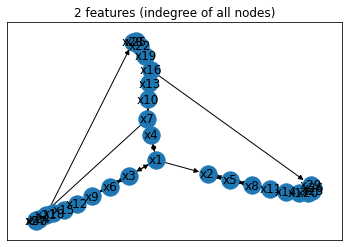

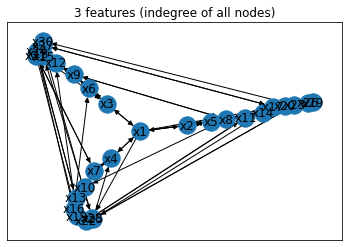

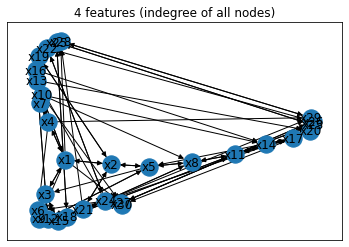

In [45]:
for i in range(2,5):
    dtab = createdependency(i, sigmasq=2)
    G = buildgraph(dtab)
    displaygraph(G, i)
    

Note: if an arrow points from node1 to node2, then node1 influenced node2, or node2 depended on node1. 

After some experimentation, it seems like the "spectral_layout" parameter is best to view the results. The nodes arrange themselves into almost a tetrahedron shape, with the edges of the tetrahedron (not to be confused with the edges of the graph) representing the three veins of feature generation as described by (1) (2) and (3) in the HW instructions. Ideally, each node x<sub>n</sub> should be connected to no other nodes besides x<sub>n+3</sub> and x<sub>n-3</sub> within the bounds for n, the exception being x<sub>1</sub> which should be connected to and from x<sub>2</sub>, x<sub>3</sub>, and x<sub>4</sub>. For the case of 2 features, this is close to being the case, with only two edges falling out of place, and the graph drifts away from the ideal structure as this number increases. 

Running these lines of code multiple times does not change the general structure or progression of the graphs, suggesting that these results are consistent and robust.

In [46]:
dict(G.adj) # for 4 features

{'x1': AtlasView({'x2': {'weight': 0.4956}, 'x3': {'weight': 0.495}, 'x4': {'weight': 0.4724}, 'x9': {'weight': 0.0316}, 'x10': {'weight': 0.0372}, 'x27': {'weight': 0.0355}, 'x28': {'weight': 0.0311}}),
 'x2': AtlasView({'x1': {'weight': 0.2061}, 'x5': {'weight': 0.5237}, 'x19': {'weight': 0.0249}, 'x21': {'weight': 0.0372}}),
 'x3': AtlasView({'x1': {'weight': 0.1925}, 'x6': {'weight': 0.4846}, 'x15': {'weight': 0.0196}}),
 'x4': AtlasView({'x1': {'weight': 0.1954}, 'x6': {'weight': 0.0166}, 'x7': {'weight': 0.499}, 'x10': {'weight': 0.0434}, 'x16': {'weight': 0.0295}, 'x29': {'weight': 0.0282}}),
 'x5': AtlasView({'x2': {'weight': 0.5059}, 'x3': {'weight': 0.0225}, 'x8': {'weight': 0.4876}, 'x12': {'weight': 0.0344}}),
 'x6': AtlasView({'x3': {'weight': 0.5086}, 'x9': {'weight': 0.5128}}),
 'x7': AtlasView({'x4': {'weight': 0.4813}, 'x10': {'weight': 0.4719}, 'x13': {'weight': 0.0374}, 'x19': {'weight': 0.0243}}),
 'x8': AtlasView({'x5': {'weight': 0.496}, 'x11': {'weight': 0.5067},

Viewing the adjacency dictionary shows us why. The two (three in the case of x<sub>1</sub>) features with greatest weights have weights substantially greater than the other features that are being connected to them. Furthermore, these two features are almost always the two that we would expect on the ideal graph structure. This means that the linear regression algorithm has learned the correct dependencies between the features for the most part: but by forcing our graph to have all of the nodes with an indegree of >2, it is trying to incorrectly incorporate these much less important relationships in the structure.

Restricting the weights of nodes to be above a certain threshold seems like a reasonable plan. 

In [47]:
def alldependentfeatures(df3):
    dependencytable = pd.DataFrame(index=df3.columns.copy(), columns=range(df3.shape[1]-1)) # get weights of all 29 features now
    # print(dependencytable)
    for i in range(1, df3.shape[1]+1): # iterate over all features
        df3 = df3[[c for c in df3.columns if c not in [f'x{i}']]+[f'x{i}']] # to move column to end
        
        x = df3.iloc[:,0:-1]
        y = df3.iloc[:,-1]
        w, xes, yname = OLS(x, y)

        together = [(xes[i], w[i]) for i in range(w.shape[0])]
        togethersort = sorted(together, key=lambda x: x[1], reverse=True) # sorts by weight
        # print(togethersort, len(togethersort), df3.shape[1])

        dependencytable.iloc[i-1] = [(f'{togethersort[j][0]}', togethersort[j][1]) for j in range(df3.shape[1]-1)]

        dptnp = dependencytable.to_numpy()
    
    return dependencytable

In [48]:
def sigmagraphs(sigmasq, threshold):
    gge = initDataframe(30)
    gge = populateDataframe(gge, 30, 5000, sigmasq)

    depgg = alldependentfeatures(gge)
    dptnp = depgg.to_numpy()
    for i in range(dptnp.shape[0]):
        for j in range(dptnp.shape[1]):
            if dptnp[i,j][1]<threshold: # 
                dptnp[i,j] = None
    newdep = pd.DataFrame(index=depgg.index.copy(), data=dptnp)
    newdep

    newG = buildgraph(newdep)
    pos = nx.spectral_layout(newG)
    nx.draw_networkx(newG, pos)
    plt.title(f'variance of {sigmasq}, threshold of {threshold}')
    # plt.figure(figsize=(5,5), dpi=100)
    plt.show()

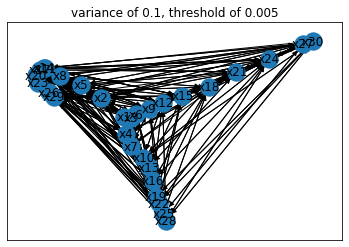

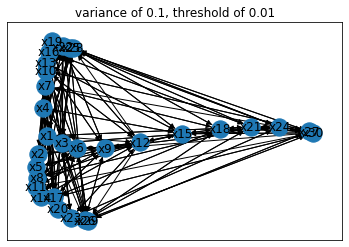

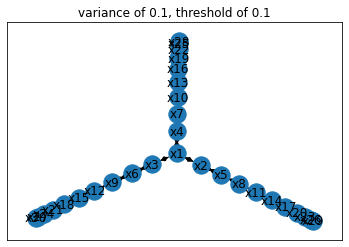

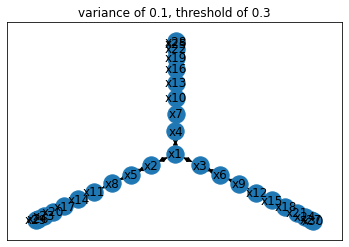

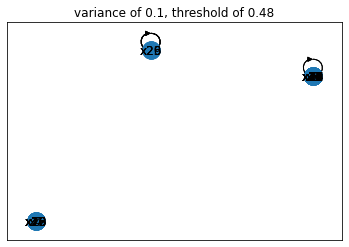

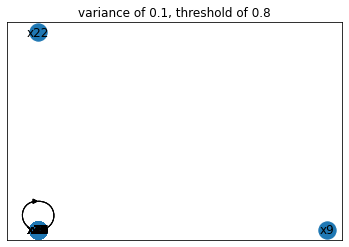

In [49]:
thresholds = np.array((0.005, 0.01, 0.1, 0.3, 0.48, 0.8))
for threshold in thresholds:
    sigmagraphs(0.1, threshold)

I handpicked some interesting values for the threshold to see how the graph would change. For much lower values, the graph is extremely dense as it visualizes almost every connection. Between around 0.1 and 0.3 is where a good spot for the threshold should be, as we can recover the true dependency graph. At higher values, the graphs break down as many edges, including meaningful ones, are lost. 

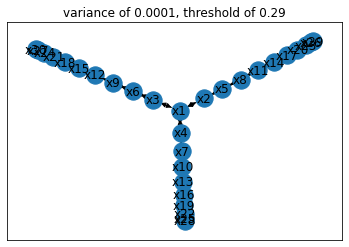

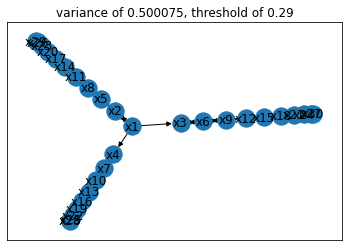

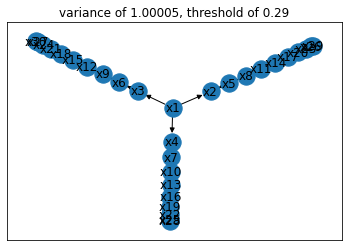

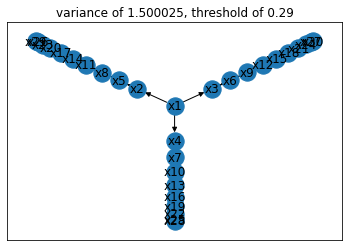

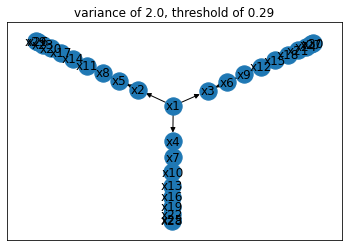

In [50]:
sigmas2 = np.linspace(0.0001, 2, 5)
for sigmasq in sigmas2:
    sigmagraphs(sigmasq, threshold=0.29)

It seems like we always generate the true dependency graph of the data using this method, regardless of the value of the variance during data generation, which makes sense as the range of the threshold to generate the true graph seemed to be large as seen previously (both 0.1 and 0.3 generated the same graph), so this large range would account for the slightly larger sigma not influencing the graph as much as expected.